# Modelo para predecir si se han abierto las ventanas en la siguiente hora

In [29]:
from tensorflow.keras.models import load_model

model_temperatura = load_model('model_predict_temperaturas.keras')


In [30]:
import pandas as pd
from datetime import time
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/content/entrenamiento_neuronal_calefaccion_gold.csv')

scaler = MinMaxScaler()

df["temperatura_predicha"] = model_temperatura.predict(scaler.fit_transform(df[['sensor.sensor_temperatura_1_humidity',
       'sensor.sensor_temperatura_1_pressure',
       'sensor.sensor_temperatura_1_temperature', 'sensor_puerta_1 Puerta',
       'suma_ventanas_arriba', 'suma_ventanas_abajo', 'azimuth_mean',
       'elevacion_sol', 'temperatura_exterior', 'porcentaje_nubes',
    'hora', 'part_of_day', 'mes', 'season',
       'hora_sin', 'hora_cos', 'dia_1', 'dia_2', 'dia_3', 'dia_4', 'dia_5',
       'dia_6']]))


# Si la suma de suma_ventanas_arriba y suma_ventanas_abajo y puerta de la siguiente fila es mayor a 15 minutos
df["ventanas_abiertas_siguiente_hora"] = (
    (df["suma_ventanas_arriba"].shift(-1) + df["suma_ventanas_abajo"].shift(-1) + df["sensor_puerta_1 Puerta"].shift(-1)) > 1200
)

df['horas'] = pd.to_datetime(df['time']).dt.time
df['dia_semana'] = pd.to_datetime(df['time']).dt.weekday  # 0 = lunes, 6 = domingo



def calefaccion(row):
    if 7 <= row['hora'] < 11 and row['temperatura_calefaccion_y'] < 22:
        return True
    elif 11 <= row['hora'] < 16 and row['temperatura_calefaccion_y'] < 21:
        return True
    elif 16 <= row['hora'] < 18 and row['temperatura_calefaccion_y'] < 21.6:
        return True
    elif 18 <= row['hora'] < 20.67 and row['temperatura_calefaccion_y'] < 22:
        return True
    else:
        return False

# Aplica la función para crear la columna 'calefaccion_encendida'
df['calefaccion_encendida'] = df.apply(calefaccion, axis=1)

# Filtramos cuando la calefacción está encendida
df = df[df['calefaccion_encendida'] == True]



# Filtra entre las 7:00 y las 21:00 y solo días entre semana (lunes a viernes)
df = df[(df['horas'] >= time(7, 0)) &
        (df['horas'] <= time(21, 0)) &
        (df['dia_semana'] < 5)]  # 0-4 para lunes a viernes

# Hacemos drop de hora despues porque se usa en la prediccion de la temperatura
df.drop(columns=['hora'], inplace=True)

# Muestra el resultado
df.drop(columns=['horas','dia_semana'], inplace=True)

X_df = df.drop(columns=["time","ventanas_abiertas_siguiente_hora", "temperatura_calefaccion_y","calefaccion_encendida"])
y_df = df["ventanas_abiertas_siguiente_hora"]

X_df.info()

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
<class 'pandas.core.frame.DataFrame'>
Index: 594 entries, 10 to 2494
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sensor.sensor_temperatura_1_humidity     594 non-null    float64
 1   sensor.sensor_temperatura_1_pressure     594 non-null    float64
 2   sensor.sensor_temperatura_1_temperature  594 non-null    float64
 3   sensor_puerta_1 Puerta                   594 non-null    float64
 4   suma_ventanas_arriba                     594 non-null    float64
 5   suma_ventanas_abajo                      594 non-null    float64
 6   azimuth_mean                             594 non-null    float64
 7   elevacion_sol                            594 non-null    float64
 8   temperatura_exterior                     594 non-null    float64
 9   porcentaje_nubes                         594 non-null    float64
 10  part_of_day   

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np

# División de datos
X_train, X_temp, y_train, y_temp = train_test_split(X_df, y_df, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Configuración del modelo
hidden_layers_config = [32]
activation = 'relu'
opt_name = 'adam'
lr = 0.001

print(f"\n🔧 Entrenando red con: capas={hidden_layers_config}, activation={activation}, optimizer={opt_name}, lr={lr}")

# Construcción del modelo
model = models.Sequential()
model.add(layers.Input(shape=(X_df.shape[1],)))
for units in hidden_layers_config:
    model.add(layers.Dense(units, activation=activation))
model.add(layers.Dense(1, activation='sigmoid'))

# Compilación
opt = optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['mae'])

# Entrenamiento
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_val, y_val))

# Evaluación
y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred_probs))

results = []
results.append({
    'layers': str(hidden_layers_config),
    'activation': activation,
    'optimizer': opt_name,
    'lr': lr,
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'mae': mae
})

print("\n📊 Resultados:")
print(results)

# Historial de entrenamiento
history_df = pd.DataFrame(history.history)
print("\n📈 Primeras filas del historial:")
print(history_df.head())


🔧 Entrenando red con: capas=[32], activation=relu, optimizer=adam, lr=0.001
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

📊 Resultados:
[{'layers': '[32]', 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001, 'accuracy': 0.9666666666666667, 'precision': 0.9743589743589743, 'recall': 0.95, 'f1_score': 0.9620253164556962, 'mae': np.float32(0.03160816)}]

📈 Primeras filas del historial:
        loss       mae   val_loss   val_mae
0  62.517883  0.493976  38.826946  0.561798
1  20.264755  0.437773   5.337205  0.161159
2   3.282177  0.087796   3.450922  0.033708
3   2.071715  0.031327   0.900997  0.022472
4   1.838531  0.028819   0.859236  0.011236


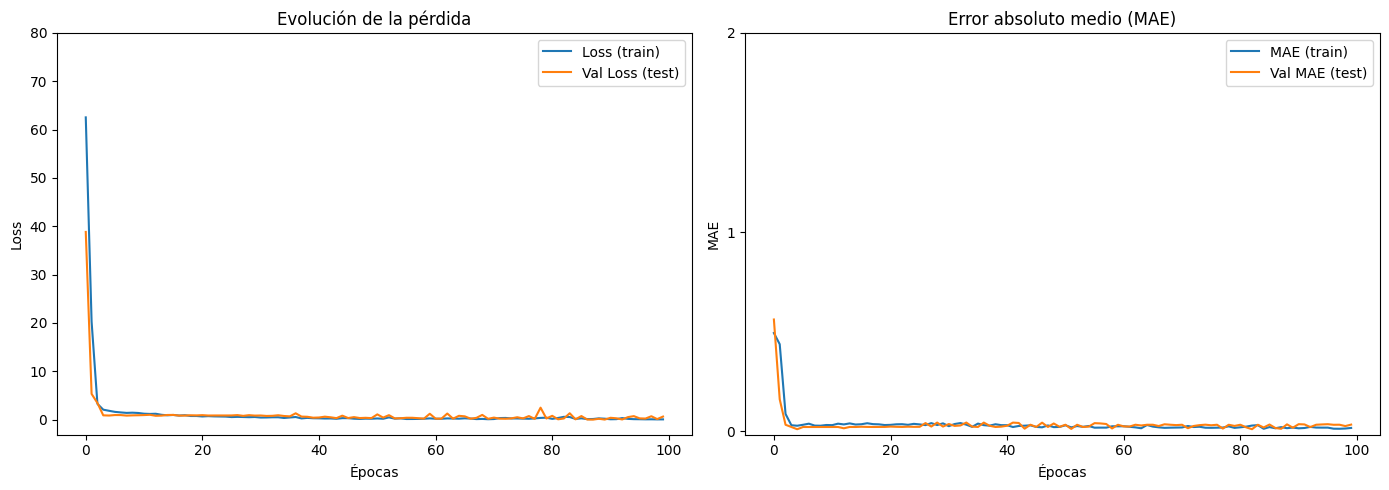

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convertir el historial a DataFrame
history_df = pd.DataFrame(history.history)

# Graficar la pérdida y el MAE
plt.figure(figsize=(14, 5))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Loss (train)')
plt.plot(history_df['val_loss'], label='Val Loss (test)')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Escala Y: 10, 20, 30, ...
loss_max = max(history_df[['loss', 'val_loss']].max())
plt.yticks(np.arange(0, loss_max + 20, 10))

# Gráfica de MAE
plt.subplot(1, 2, 2)
plt.plot(history_df['mae'], label='MAE (train)')
plt.plot(history_df['val_mae'], label='Val MAE (test)')
plt.title('Error absoluto medio (MAE)')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

# Escala Y: 1, 2, 3, ...
mae_max = max(history_df[['mae', 'val_mae']].max())
plt.yticks(np.arange(0, mae_max + 2, 1))  # +2 por si sube justo al siguiente entero

plt.tight_layout()
plt.show()

In [33]:
y_pred = model.predict(X_test).flatten()

# Crear una copia del DataFrame original con las filas correspondientes a X_test
df_test = df.loc[X_test.index].copy()

# Añadir columna con las predicciones
df_test["predic se abrira"] = y_pred > 0.5

output_path = "predicciones_se_abrira.csv"
df_test.to_csv(output_path, index=False)
output_path

model.save("model_predicciones_se_abrira.keras")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import itertools

# Dividir en train, val, test
X_train, X_temp, y_train, y_temp = train_test_split(X_df, y_df, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Parámetros para probar
hidden_layers_list = [[32], [64, 32], [128, 64, 32]]
activations = ['relu', 'tanh']
optimizers_list = [
    ('adam', 0.001),
    ('sgd', 0.01),
    ('rmsprop', 0.0005),
]

results = []

# Generar combinaciones
combinations = list(itertools.product(hidden_layers_list, activations, optimizers_list))

for i, (hidden_layers_config, activation, (opt_name, lr)) in enumerate(combinations, 1):
    print(f"\n🔧 Probando modelo {i}/{len(combinations)}: capas={hidden_layers_config}, activation={activation}, optimizer={opt_name}, lr={lr}")

    model = models.Sequential()
    model.add(layers.Input(shape=(X_df.shape[1],)))
    for units in hidden_layers_config:
        model.add(layers.Dense(units, activation=activation))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Elegir optimizador
    if opt_name == 'adam':
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_name == 'sgd':
        opt = optimizers.SGD(learning_rate=lr)
    elif opt_name == 'rmsprop':
        opt = optimizers.RMSprop(learning_rate=lr)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_val, y_val))

    # Evaluación
    y_pred_probs = model.predict(X_test).ravel()
    y_pred = (y_pred_probs > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    results.append({
        'layers': str(hidden_layers_config),
        'activation': activation,
        'optimizer': opt_name,
        'lr': lr,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
    })

# Mostrar resultados ordenados
df_resultados = pd.DataFrame(results)
print("\nTop resultados:")
print(df_resultados.head(10).to_string(index=False))


🔧 Probando modelo 1/18: capas=[32], activation=relu, optimizer=adam, lr=0.001
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

🔧 Probando modelo 2/18: capas=[32], activation=relu, optimizer=sgd, lr=0.01
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

🔧 Probando modelo 3/18: capas=[32], activation=relu, optimizer=rmsprop, lr=0.0005
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

🔧 Probando modelo 4/18: capas=[32], activation=tanh, optimizer=adam, lr=0.001
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

🔧 Probando modelo 5/18: capas=[32], activation=tanh, optimizer=sgd, lr=0.01
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

🔧 Probando modelo 6/18: capas=[32], activation=tanh, optimizer=rmsprop, lr=0.0005
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

🔧 Probando modelo 7/18: capas=[64, 32], activation=relu, optimizer=adam, lr=0.001
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

🔧 Probando modelo 8/18: capas=[64, 32], activation=relu, optimizer=sgd, lr=0.01
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

🔧 Probando modelo 9/18: capas=[64, 32], activation=re

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

🔧 Probando modelo 16/18: capas=[128, 64, 32], activation=tanh, optimizer=adam, lr=0.001
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

🔧 Probando modelo 17/18: capas=[128, 64, 32], activation=tanh, optimizer=sgd, lr=0.01
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

🔧 Probando modelo 18/18: capas=[128, 64, 32], activation=tanh, optimizer=rmsprop, lr=0.0005
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Top resultados:
       layers activation optimizer     lr  accuracy  precision  recall  
     [64, 32]       tanh       sgd 0.0100  1.000000   1.000000   1.000  
         [32]       tanh   rmsprop 0.0005  0.988889   0.975610   1.000  
[128, 64, 32]       tanh      adam 0.0010  0.988889   0.975610   1.000  
[128, 64, 32]       tanh       sgd 0.0100  0.988889   0.975610   1.000  
     [64, 32]       tanh   rmsprop 0.0005  0.988889   0.975610   1.000  
[128, 64, 32]       relu      adam 0.0010  0.977778   0.952381   1.000  
[128, 64, 32]       tanh   rmsprop 0.0005  0.977778